<a href="https://colab.research.google.com/github/YounesBKL/YounesBKL/blob/main/Marketing_Attribution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project description





*   This project aims to demonstrate how to build a Marketing Attribution Model (MMM) using a regression-based approach to quantify the impact of various advertising channels and control variables on revenue generation.
*  The dataset describes the sales generated from icecream store.



I will consider the following :



*   Feature engineering of marketing-specific variables such as Ad Stock (Decay) and Diminishing Returns (saturation) to account for lagged and non-linear effects of marketing efforts.
*   Incorporating control variables (e.g., seasonality, price changes, macro trends) to isolate the true incremental impact of marketing.

By the end of this project, we will have developed a model capable of predicting the performance of ongoing marketing activities and estimating their influence on revenue and Return on Investment (ROI).



In [4]:
# Mount Google Drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/MyDrive/Colab_Datasets/Linkedin_learning_Marketing_Mix_Modeling.xlsx'

# Automatically load the dataset
try:
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully!")
    print(df.head())
except FileNotFoundError:
    print(f"The file at {file_path} was not found. Please check the path.")

Mounted at /content/drive
Dataset loaded successfully!
   Week  Revenue  Newspaper Ads  Search Ads  Social Ads  Price Change  \
0     1  3302.99              0           0           0           0.0   
1     2  2706.27              0           0           0           0.0   
2     3  2330.41              0           0           0           0.0   
3     4  2351.63              0           0           0           0.0   
4     5  2398.48              0          10           0           0.0   

   Temperature  Holiday  
0         39.8        1  
1         37.3        0  
2         38.6        0  
3         32.3        0  
4         34.9        0  


In [5]:
#Let's first conduct some basci data quality check

 #import necessary libraries
import pandas as pd
import numpy as np

# Check for missing values
missing_values = df.isnull().sum()

# Check data types
data_types = df.dtypes

# Summary statistics for numeric columns
summary_stats = df.describe()

# Check for outliers using IQR method on key numeric features
numeric_cols = ['Revenue', 'Newspaper Ads', 'Search Ads', 'Social Ads', 'Price Change', 'Temperature']
outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = {
        'outlier_count': outliers.shape[0],
        'outlier_percentage': (outliers.shape[0] / df.shape[0]) * 100
    }

# Convert outlier summary to DataFrame
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='outlier_count', ascending=False).round(2)

# Display outputs
print("🔍 Missing Values:")
print(missing_values)
print("\n📊 Data Types:")
print(data_types)
print("\n📈 Summary Statistics:")
print(summary_stats)
print("\n🚨 Outlier Summary:")
display(outlier_df)  # `display()` works well in Jupyter/Colab


🔍 Missing Values:
Week             0
Revenue          0
Newspaper Ads    0
Search Ads       0
Social Ads       0
Price Change     0
Temperature      0
Holiday          0
dtype: int64

📊 Data Types:
Week               int64
Revenue          float64
Newspaper Ads      int64
Search Ads         int64
Social Ads         int64
Price Change     float64
Temperature      float64
Holiday            int64
dtype: object

📈 Summary Statistics:
            Week      Revenue  Newspaper Ads  Search Ads  Social Ads  \
count  52.000000    52.000000      52.000000   52.000000   52.000000   
mean   26.500000  3444.464231      46.153846   19.615385   18.846154   
std    15.154757   870.856511      85.087126   15.141365   40.687901   
min     1.000000  2323.120000       0.000000    0.000000    0.000000   
25%    13.750000  2728.377500       0.000000   10.000000    0.000000   
50%    26.500000  3310.905000       0.000000   15.000000    0.000000   
75%    39.250000  3958.317500       0.000000   20.000000    0

,outlier_count,outlier_percentage
Newspaper Ads,12.0,23.08
Search Ads,12.0,23.08
Social Ads,12.0,23.08
Revenue,0.0,0.00
Price Change,0.0,0.00
Temperature,0.0,0.00


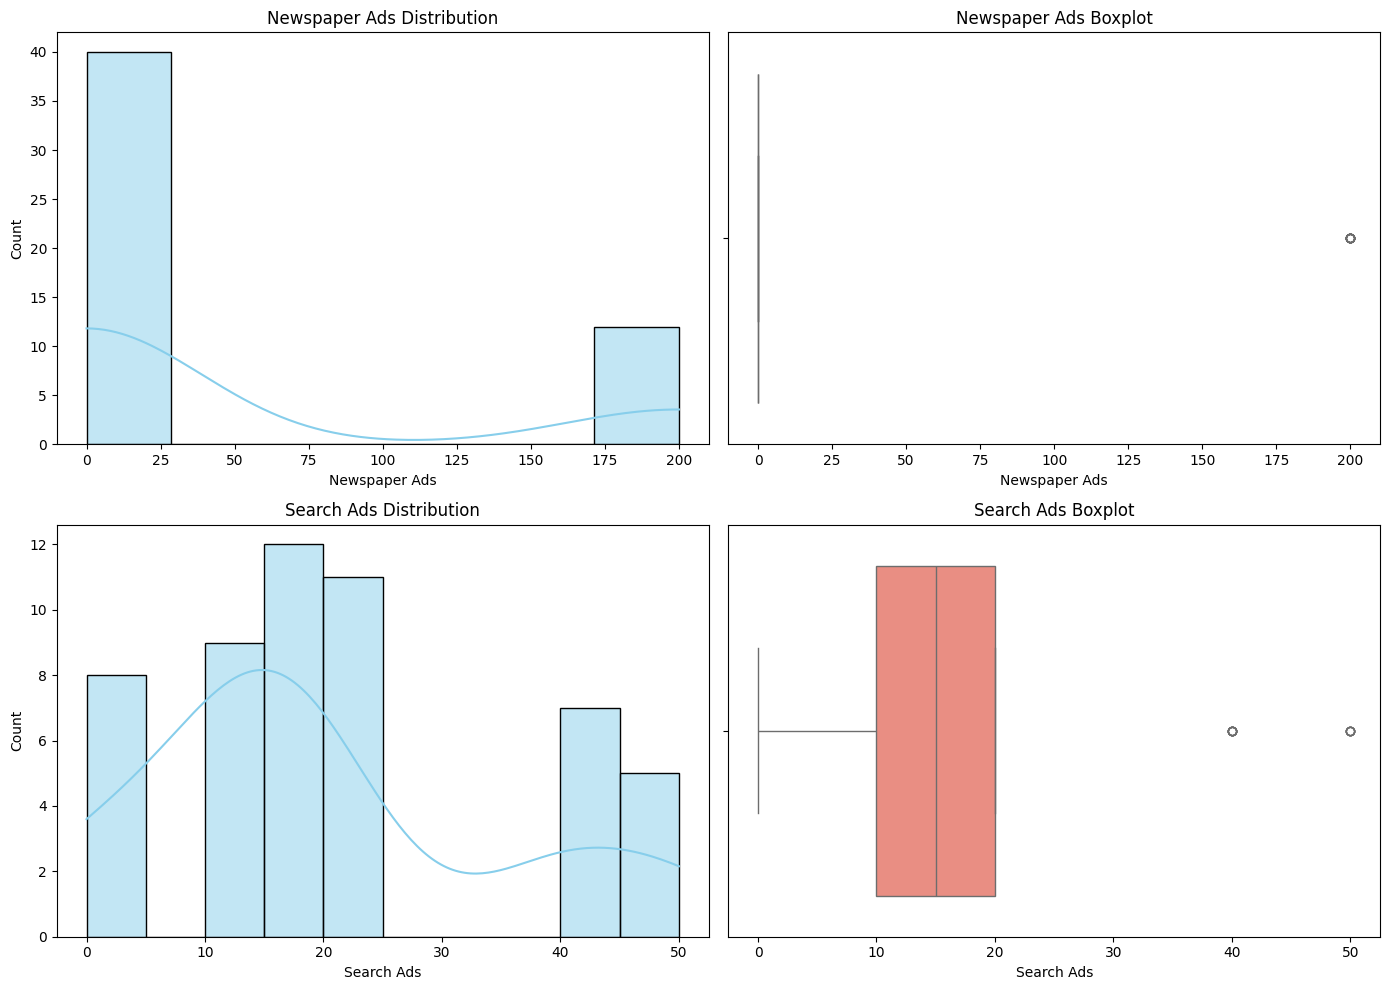

In [6]:
# Visualize the distribution of features with the most outliers
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib.pyplot and alias it as plt
top_outlier_features = outlier_df.index[:2].tolist()  # 'Social Ads' and 'Newspaper Ads'

# Plot histograms and boxplots for each
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(top_outlier_features):
    # Histogram
    sns.histplot(df[feature], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{feature} Distribution')
    axes[i, 0].set_xlabel(feature)

    # Boxplot
    sns.boxplot(x=df[feature], ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'{feature} Boxplot')
    axes[i, 1].set_xlabel(feature)

plt.tight_layout()
plt.show()


# Observations:
Both features are heavily right-skewed, with long tails.

*   Majority of values are zero or low, with a few high spikes (outliers).
*   These spikes likely represent campaign bursts, which may be real events, not data errors.
*   We will keep them for now and assess if they will distort our model


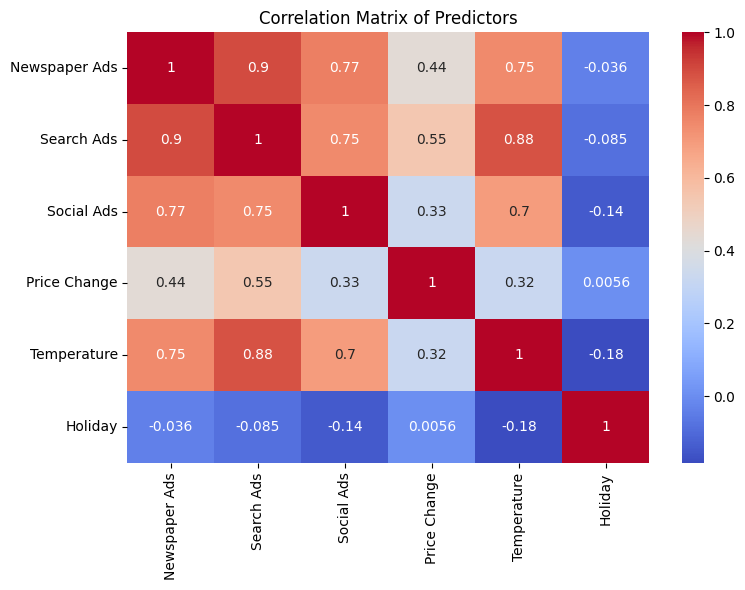

,Feature,VIF
0,Newspaper Ads,6.711116
1,Search Ads,15.473175
2,Social Ads,2.764809
3,Price Change,1.820456
4,Temperature,6.237971
5,Holiday,1.082162


In [7]:
# lets look at the correlation with different variables and assess the multicolinearity by calculating VIF score

# Import necessary function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric predictors (excluding target and week)
X = df[['Newspaper Ads', 'Search Ads', 'Social Ads', 'Price Change', 'Temperature', 'Holiday']]

# 1. Correlation Matrix
correlation_matrix = X.corr()

# 2. VIF Calculation
X_vif = X.copy()
X_vif['Intercept'] = 1  # statsmodels requires intercept
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X.columns))]

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Predictors")
plt.tight_layout()
plt.show()

vif_data

The correlation heatmap shows moderate to strong correlations, especially between Search Ads and other features likely a cause of multicollinearity.The VIF score also explain the high multicolinearity of the search ad which might impact the model performance.

To proceed, we have two paths to handle multicollinearity:



*   Drop or Combine highly correlated features (e.g., reduce Search Ads or combine all digital ads). This method is not suitable in the case of our usecase where we want to understand the contribution of each ads to the sales.  
*   Apply Regularization ( Ridge or Lasso regression, which handles multicollinearity without dropping).

We will keep all features and use Ridge regression which handle multicollinearity very well.





In [8]:
 # Step 1: let's first Build a baseline model without adstock and saturation. This will allow us to understand how big is the impact of adstock and saturation on model performance later

# Define the original features
baseline_features = ['Newspaper Ads', 'Search Ads', 'Social Ads', 'Price Change', 'Temperature', 'Holiday']
X_baseline = df[baseline_features]
y_baseline = df['Revenue']

# Standardize the features :transforms all input features to have zero mean and unit variance (z-scores) to normalize the features and remove the impact of large scale dominance on the model
# Let's import the required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np # Import numpy to use sqrt

# Standardizing the features helps to prevent features with larger numerical ranges from dominating the model's learning process.
# It ensures that all features contribute equally to the model's performance, regardless of their original units or scales.
scaler = StandardScaler()
X_baseline_scaled = scaler.fit_transform(X_baseline)

# Train/test split, 80% training, 20% testing
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_baseline_scaled, y_baseline, test_size=0.2, random_state=42)

# adding regularization to remove multicolinearity and avoid overfitting
ridge_base = Ridge(alpha=1.0)
ridge_base.fit(X_train_base, y_train_base)

# Evaluate
y_pred_base = ridge_base.predict(X_test_base)
r2_base = r2_score(y_test_base, y_pred_base)

# Calculate MSE first, then take the square root for RMSE
mse_base = mean_squared_error(y_test_base, y_pred_base)
rmse_base = np.sqrt(mse_base)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': baseline_features,
    'Coefficient': ridge_base.coef_
}).sort_values(by='Coefficient', ascending=False)

r2_base, rmse_base, coefficients


(0.9701231658801857,
 np.float64(141.2953441880606),
          Feature  Coefficient
 0  Newspaper Ads   359.063980
 4    Temperature   353.428023
 5        Holiday   296.012309
 2     Social Ads   170.443589
 1     Search Ads    89.653747
 3   Price Change  -232.751045)


#Observations

*  News paper ads and holiday strongly boosted revenue.
*  Warmer weeks are likely to increase revenue. This is expected given that it is an icecream business
*   Price increase has negative impact on sales. Customers seems sensitive to the price change applied on the icecream.
*   Search ads and social ads has a moderate to small impact on sales. This suggest to revise the marketing budget and move more budget towards newspaper ads.  






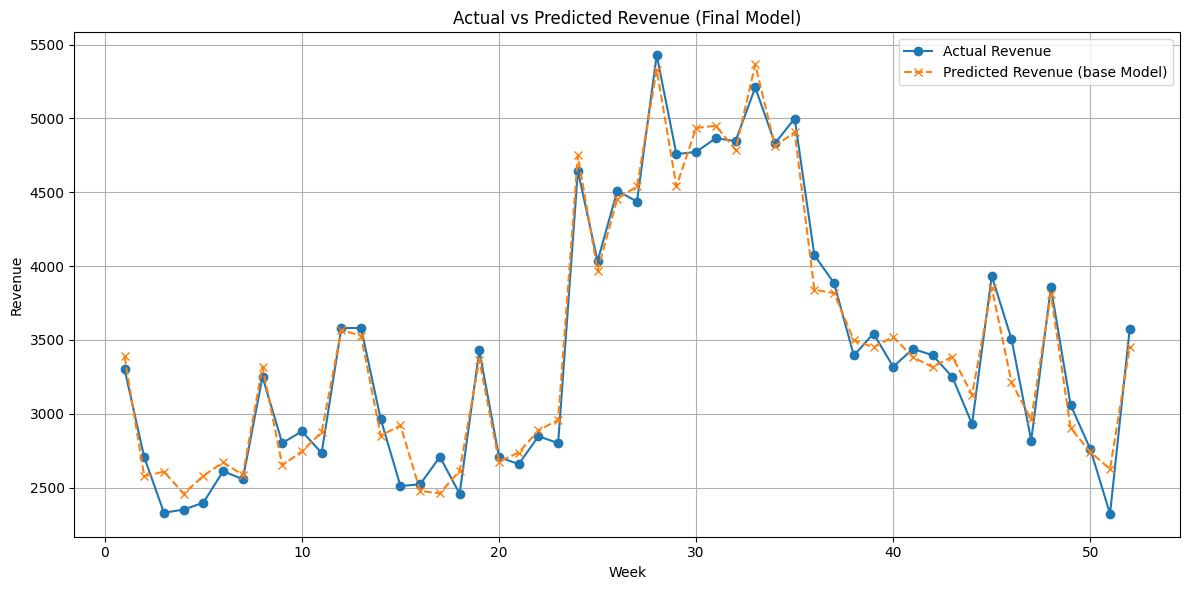

In [9]:
# Plot predicted vs actual
y_pred_base = ridge_base.predict(X_baseline_scaled)
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['Revenue'], label='Actual Revenue', marker='o')
plt.plot(df['Week'], y_pred_base, label='Predicted Revenue (base Model)', linestyle='--', marker='x')
plt.title('Actual vs Predicted Revenue (Final Model)')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

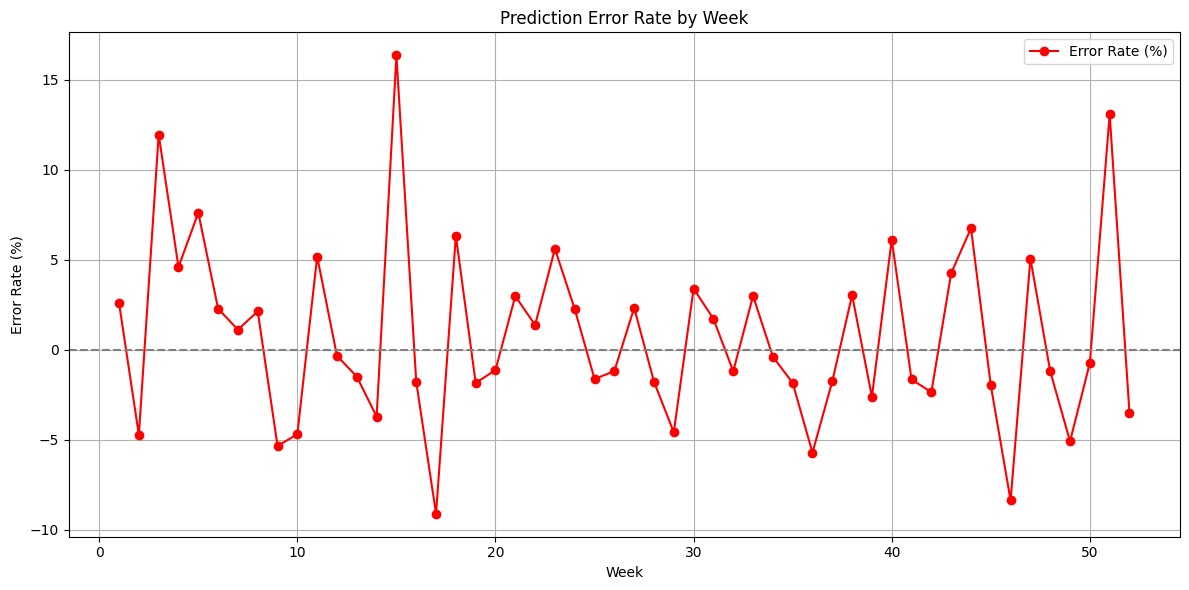

In [13]:
 #Display the r2_base in a line chart vs week

# Calculate error rate %
df['Actual Revenue'] = y_baseline
df['Predicted Revenue'] = y_pred_base
df['Error (%)'] = ((df['Predicted Revenue'] - df['Actual Revenue']) / df['Actual Revenue']) * 100

# Plot error rate
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['Error (%)'], marker='o', color='red', label='Error Rate (%)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Prediction Error Rate by Week')
plt.xlabel('Week')
plt.ylabel('Error Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Observation
This is already a very strong model, which suggests:


*   the spend variables have good predictive power.
*   However, adstock and saturation may still help improve interpretability, causality, and budget planning realism even if marginally.


# Next step
We will now do grid search for Best adstock decay and best saturation exponent and then retrain the model by adding these features.



#What is Adstock decay
The decay coefficient (let’s call it λ) controls how much of last week's spend carries over to the current week:
# Adstock_t =Spend_t +λ* Adstock_t−1

​If λ=0: No carryover
If λ=0.9: Long-lasting effect (e.g., TV ads)
If λ=0.3: Short-lived effect (e.g., search ads)

# How to determine the best decay
There are many options that can be applied.
Option 1 : Grid Search (Manual Tuning)
Option 2 : Bayesian Optimization / ML Model Fit ==> this Treat decay λ as a hyperparameter and optimize it using cross validation and baysaian optimization ( more complex)
Option 3 : heuristic by channel type

| Channel        | Typical Decay Range | Reason                        |
| -------------- | ------------------- | ----------------------------- |
| TV             | 0.7 – 0.9           | High memorability             |
| Radio          | 0.5 – 0.7           | Medium recall                 |
| Digital Search | 0.1 – 0.3           | Immediate, short-lived impact |
| Social Media   | 0.2 – 0.4           | Moderate engagement decay     |
| Email/In-App   | 0.1 – 0.3           | Shortest effect               |



# What is the Saturation Coefficient (β)?
It models the diminishing returns of media spend after adstock ( let's call it x) that is determined using one of the above methods.

Saturation(𝑥)=𝑥^𝛽  with 0 <𝛽 ≤1

β=1: Linear,no saturation.
β=0.5: Square root,moderate diminishing returns.
β=0.3: Strong saturation,flattening effect
β < 0.1: Spend nearly ineffective after initial point:

#How to Determine the Best Saturation Value

1.   Choose a fixed decay (e.g., λ = 0.1 from our last result).
2.   Apply adstock.
3.   Loop over different β values (e.g., from 0.1 to 1.0).
4.   Apply saturation based on the above formula
5.   Fit the Ridge model and evaluate R² score.  
6.   Choose the β that gives the best fit.








In [15]:
# Define function to apply adstock
def apply_adstock(series, decay):
    result = [series[0]]
    for i in range(1, len(series)):
        result.append(series[i] + decay * result[i-1])
    return result

# Define function to apply both adstock and saturation with given parameters
def transform_with_decay_and_saturation(df, decay, beta):
    df_temp = df.copy()
    # Apply adstock
    df_temp['Newspaper Ads (adstock)'] = apply_adstock(df_temp['Newspaper Ads'], decay)
    df_temp['Search Ads (adstock)'] = apply_adstock(df_temp['Search Ads'], decay)
    df_temp['Social Ads (adstock)'] = apply_adstock(df_temp['Social Ads'], decay)

    # Apply saturation
    df_temp['Newspaper Ads (sat)'] = df_temp['Newspaper Ads (adstock)'] ** beta
    df_temp['Search Ads (sat)'] = df_temp['Search Ads (adstock)'] ** beta
    df_temp['Social Ads (sat)'] = df_temp['Social Ads (adstock)'] ** beta

    return df_temp

# Grid search over decay and beta
decay_range = np.arange(0.1, 1.0, 0.1)
beta_range = np.arange(0.1, 1.1, 0.1)
grid_results = []

for decay in decay_range:
    for beta in beta_range:
        df_transformed = transform_with_decay_and_saturation(df, decay, beta)
        features = ['Newspaper Ads (sat)', 'Search Ads (sat)', 'Social Ads (sat)', 'Price Change', 'Temperature', 'Holiday']
        X = df_transformed[features]
        y = df_transformed['Revenue']
        # The scaler was defined earlier, so it should be available in the global scope
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model = Ridge(alpha=1.0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        grid_results.append({'decay': decay, 'beta': beta, 'r2': r2, 'rmse': rmse})

# Convert to DataFrame and sort
grid_results_df = pd.DataFrame(grid_results).sort_values(by='r2', ascending=False)
grid_results_df.sort_values(by='rmse').head(10)

,decay,beta,r2,rmse
29,0.3,1.0,0.972644,135.204372
28,0.3,0.9,0.972380,135.854600
39,0.4,1.0,0.972160,136.394470
19,0.2,1.0,0.972051,136.661097
18,0.2,0.9,0.972014,136.750825
17,0.2,0.8,0.971952,136.901868
27,0.3,0.8,0.971942,136.927960
16,0.2,0.7,0.971728,137.449219
38,0.4,0.9,0.971549,137.883450
6,0.1,0.7,0.971454,138.111376


#Optimal Adstock and Saturation Parameters (Grid Search Results)

| Rank | Decay (λ) | Saturation (β) | R² Score     | RMSE   |
| ---- | --------- | -------------- | ------------ | ------ |
| 1    | **0.3**   | **1.0**        | **0.9726**  | 135.20 |
| 2    | 0.3       | 0.9            | 0.9724       | 135.85 |
| 3    | 0.4       | 1.0            | 0.9722       | 136.39 |
| 4    | 0.2       | 1.0            | 0.9721       | 136.66 |
| 5    | 0.2       | 0.9            | 0.9720       | 136.75 |

#Interpretation

The best combination is:

Decay λ=0.3

Saturation exponent  β=1.0 → linear, i.e., no diminishing return

This means: Adstock matters, but diminishing returns may not be strong in the current data.

In [ ]:
#lets visualize the adstock for
# Plot raw vs adstocked spend for each ad channel (remove saturation)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))

for i, channel in enumerate(['Newspaper Ads', 'Search Ads', 'Social Ads']):
    ax = axes[i]
    raw = df[channel]
    adstocked = apply_adstock(raw, decay=0.3)

    ax.plot(df['Week'], raw, label='Raw Spend', linestyle='-', marker='o')
    ax.plot(df['Week'], adstocked, label='Adstocked Spend (λ=0.3)', linestyle='--', marker='x')
    ax.set_title(f'{channel}: Raw vs Adstocked Spend (Decay = 0.3)')
    ax.set_xlabel('Week')
    ax.set_ylabel('Spend')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


#Interpretation
Newspaper ads  have lasting influence even after the spend stops, consistent with print ad memory effects. the effect lasted for 3 weeks
Search ads drive immediate attention, but adstock suggests continued brand or product recall over the next= week once we stop spends
Social media may generate discussions or saved content that continues to affect user behavior even after the campaign ends.


#Now that we have a ready regression model which accounts for the impact of each marketing channel including the impact of adstock and saturation, we can use the model to estimate the ROI based on the average spend of each channel and the attributed revenue calculated from the coefficient of the regression model.

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np # Import numpy for sqrt
from IPython.display import display


# Reapply adstock and saturation using best parameters
df_transformed = transform_with_decay_and_saturation(df, decay=0.3, beta=1.0)

# Define final features and target
features = ['Newspaper Ads (sat)', 'Search Ads (sat)', 'Social Ads (sat)', 'Price Change', 'Temperature', 'Holiday']
X = df_transformed[features]
y = df_transformed['Revenue']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Ridge model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_scaled, y)

# Extract ad channel coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge_model.coef_
}).set_index('Feature')

# Calculate average saturated spend for ROI
avg_spend = df_transformed[['Newspaper Ads (sat)', 'Search Ads (sat)', 'Social Ads (sat)']].mean()

# Extract corresponding coefficients
ad_channels = ['Newspaper Ads (sat)', 'Search Ads (sat)', 'Social Ads (sat)']
roi_df = pd.DataFrame({
    'Avg_Saturated_Spend': avg_spend,
    'Coefficient': coef_df.loc[ad_channels, 'Coefficient']
})
roi_df['ROI'] = roi_df['Coefficient'] / roi_df['Avg_Saturated_Spend']

# Sort by ROI descending
roi_df = roi_df.sort_values(by='ROI', ascending=False).round(2)
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index': 'Channel'}, inplace=True)
print("📊 ROI Summary")
display(roi_df)


📊 ROI Summary


,Channel,Avg_Saturated_Spend,Coefficient,ROI
0,Newspaper Ads (sat),65.93,378.49,5.74
1,Search Ads (sat),28.02,126.71,4.52
2,Social Ads (sat),26.92,114.36,4.25


# ROI Interpretation
News paper ad has the highest ROI which is a strong candidate for scaling
Search ads has and social ads has also a solid performance which indicates that the strategy used is already well optimized.



Before we move to test different budget attribution value, we would like to run some statistical tests to ensure that our model does not suffer from skewness or heavy tailed errors. For this we can evaluate skewness and Kurtosis.


In [17]:
from scipy.stats import skew, kurtosis

# Calculate residuals from the final model (actual - predicted)
features = ['Newspaper Ads (sat)', 'Search Ads (sat)', 'Social Ads (sat)', 'Price Change', 'Temperature', 'Holiday']
X = df_transformed[features]
y = df_transformed['Revenue']

# Standardize and fit the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_scaled, y)

# Residuals
y_pred = ridge_model.predict(X_scaled)
residuals = y - y_pred

# Calculate skewness and kurtosis
residual_skewness = skew(residuals)
residual_kurtosis = kurtosis(residuals)

residual_skewness, residual_kurtosis


(np.float64(-0.07308218795387919), np.float64(0.34028848960527824))

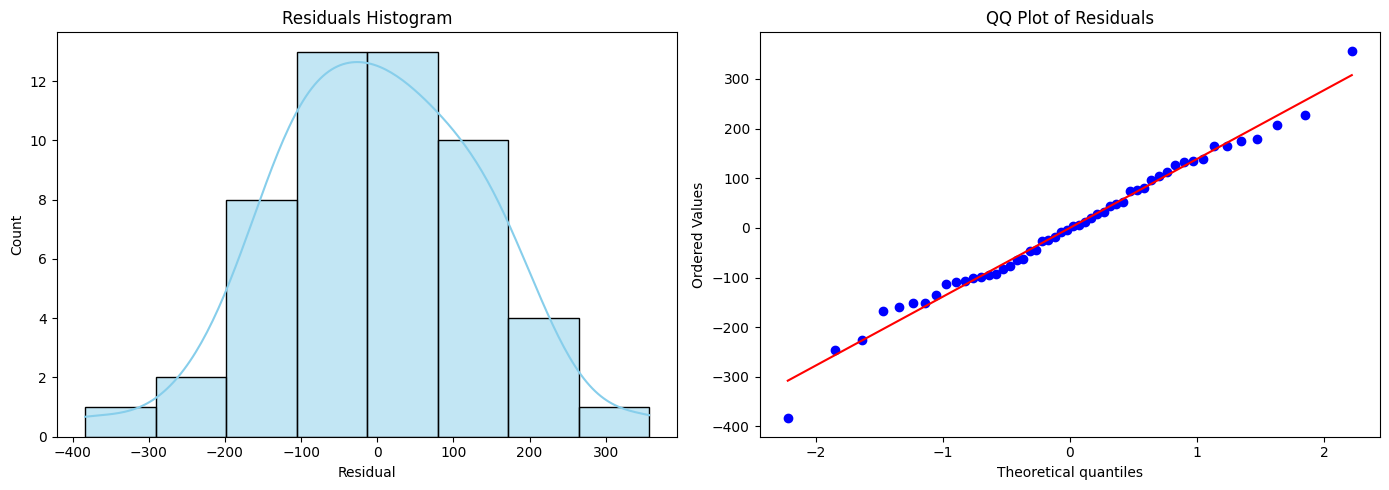

In [22]:
import matplotlib.pyplot as plt # Ensure matplotlib.pyplot is imported
import seaborn as sns # Ensure seaborn is imported
import scipy.stats as stats # Import the entire stats module and alias it as stats


# Plot histogram and QQ plot of residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
sns.histplot(residuals, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Residuals Histogram')
axes[0].set_xlabel('Residual')

# QQ plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

Sknewness is Close to 0, which means the residuals are nearly symmetric.No strong left or right tail → errors are not systematically over- or under-predicting.
This Suggests no major bias in the model’s predictions.

Kurtosis is close to normal distribution. The model does not suffer from strong outliers, asymmetry, or heavy-tailed errors


#Next step
Now that we know that Newspaper ad has the highest ROI, we can simulate attributing a higher budget to it while keep the total budget constraints same. Basically this increase the budget share of the newspaper ads and reduce the share of the other channels. This helps us understand if we can drive a higher revenue by allocating more budget to newspapaer ads.
